In [1]:

import os
import pathlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import subprocess
import librosa
import python_speech_features

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [ ]:
data = pd.read_table("../Data/fin/cv-corpus-12.0-2022-12-07/fi/validated.tsv")
data.dropna(axis=1, inplace=True)
data.drop("down_votes", axis=1, inplace=True)
data.drop("locale", axis=1, inplace=True)
data.drop("up_votes", axis=1, inplace=True)
counts = data["client_id"].value_counts(ascending=True)
singles = counts.where(counts.values == 1).dropna(axis=0)
to_drop = singles.index

for id in to_drop:
    data = data[data.client_id != id]

all_classes = data.client_id.unique()


for idx, classname in enumerate(all_classes):
    data["client_id"] = data["client_id"].replace(classname, idx)

data.rename(columns={"client_id": 'Class'}, inplace=True)

train, validation = train_test_split(data, test_size=0.2)

train_classes = train.Class.unique()
#ensure that the whole class-set is represented in the training data
while(train_classes.size < all_classes.size):
    train, validation = train_test_split(data, test_size=0.2)

    train_classes = train.Class.unique()

for c in train_classes:
    if(len(os.listdir("..\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\training_set\\")) == 0 and len(os.listdir(".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\validation_set\\")) == 0):
        os.mkdir(
            "..\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\training_set\\"+str(c))
        os.mkdir(
            "..\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\validation_set\\"+str(c))
    else:
        continue


In [ ]:

transform = True
i = 1
if(transform):
    directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/clips/"
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if(os.path.isfile(f) and not (data.path[data.path == filename].empty)):
            i += 1
            print(i)
            mp3_to_wav(f)


In [ ]:
#Change the pathnames to match with the .wav format
for path in train.path:
    new_path = path[:-3]+"wav"
    train["path"] = train.path.replace(path, new_path)


for path in validation.path:
    new_path = path[:-3]+"wav"
    validation["path"] = validation.path.replace(path, new_path)


In [ ]:
def mp3_to_wav(file):
    filename = pathlib.Path(file).stem
    if(not (train.path[train.path == filename+".mp3"].empty)):
        classname = str(train.Class[train.path == filename+".mp3"].item())
        output = "..\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\training_set\\" + \
            classname+"\\"+filename+".wav"
        print(output)
        subprocess.call(["ffmpeg", "-i", file, output])
    if(not (validation.path[validation.path == filename+".mp3"].empty)):
        classname = str(
            validation.Class[validation.path == filename+".mp3"].item())
        output = "..\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\validation_set\\" + \
            classname+"\\"+filename+".wav"
        print(output)
        subprocess.call(["ffmpeg", "-i", file, output])
    #sound = AudioSegment.from_mp3(file)
    #file = sound.export(filename, format="wav")


In [11]:

import os
from pydub import AudioSegment, silence, playback
def trim(directory, output, trim_len):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        new_dir = os.path.join(output, filename)
        # checking if it is a file
        if(os.path.isdir(f)):
            for file in os.listdir(f):
                new_audiopath = os.path.join(new_dir, file)
                print(new_audiopath)
                audiopath = os.path.join(f, file)
                audio = AudioSegment.from_wav(audiopath)
                duration = len(audio)
                audio = audio[duration/4:-duration/4]
                silence_thresh = audio.dBFS -1
                start_trim = silence.detect_leading_silence(
                    audio, silence_threshold=silence_thresh, chunk_size=5)
                end_trim = silence.detect_leading_silence(
                    audio.reverse(), silence_threshold=silence_thresh, chunk_size=5)
                trimmed_audio = audio[start_trim:duration-end_trim]
                #print(len(trimmed_audio)/1000, duration/1000)
                while(trimmed_audio.duration_seconds < trim_len):
                    trimmed_audio = trimmed_audio + trimmed_audio

                if(trimmed_audio.duration_seconds > trim_len):  # Trim each to exactly X seconds
                    trimmed_audio = trimmed_audio[:trim_len*1000]
                if(not os.path.isdir(new_dir)):
                    os.makedirs(new_dir)
                trimmed_audio = trimmed_audio.set_frame_rate(16000)
                trimmed_audio.export(new_audiopath, format="wav")


In [8]:
import os
import random
import string
import pathlib
from pydub import AudioSegment, silence, playback


def trim2(directory, output, trim_len):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        new_dir = os.path.join(output, filename)
        if(not os.path.isdir(new_dir)):
            os.makedirs(new_dir)
        # checking if it is a file
        if(os.path.isdir(f)):
            for file in os.listdir(f):
                audiopath = os.path.join(f, file)
                audio = AudioSegment.from_wav(audiopath)
                silence_thresh = audio.dBFS - 1
                nonsilents = silence.detect_nonsilent(audio, min_silence_len=500, seek_step=1, silence_thresh=silence_thresh)

                for clip in nonsilents:
                    trimmed_audio = audio[clip[0]:clip[1]]
                    while(trimmed_audio.duration_seconds < trim_len):
                        trimmed_audio = trimmed_audio + trimmed_audio

                    if(trimmed_audio.duration_seconds > trim_len):  # Trim each to exactly X seconds
                        trimmed_audio = trimmed_audio[:trim_len*1000]
                    letters = string.ascii_lowercase
                    result_str = ''.join(random.choice(letters) for i in range(6))
                    new_audiopath = os.path.join(new_dir, pathlib.Path(audiopath).stem)
                    new_clip = new_audiopath+"_"+result_str+".wav"
                    trimmed_audio = trimmed_audio.set_frame_rate(16000).set_channels(1)
                    print(new_clip)
                    trimmed_audio.export(new_clip, format="wav")


In [9]:
import shutil
val_directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/validation_set"
train_directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/training_set"
nonsilent_output = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset"
length = 1
if(shutil.os.path.isdir(nonsilent_output)):
    shutil.rmtree(nonsilent_output)
if(shutil.os.path.isdir(nonsilent_output)):
    shutil.rmtree(nonsilent_output)





In [10]:
trim2(val_directory, nonsilent_output, length)
trim2(train_directory, nonsilent_output, length)

../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996615_lwhams.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996619_bozrsa.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996622_csyxwh.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996622_imdsvq.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996622_yevzjw.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996759_neofqb.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996781_psxytt.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996914_yopubf.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/nonsilent_trimmed_dataset\100\common_voice_fi_22996914_iia

In [12]:

val_directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/validation_set"
train_directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/training_set"
val_output = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set"
train_output = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_training_set"
length = 2

trim(val_directory, val_output, length)
trim(train_directory, train_output, length)




../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996615.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996619.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996622.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996759.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996781.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996914.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996916.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22996961.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_voice_fi_22997036.wav
../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set\100\common_vo

In [ ]:
directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_training_set/116"

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if(os.path.isfile(f)):
        audio = AudioSegment.from_wav(f)
        playback.play(audio-20)


In [ ]:
import librosa
import matplotlib.pyplot as plt

audio_file = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_training_set\99\common_voice_fi_23212820.wav"

signal, sr = librosa.load(audio_file)


mfccs = librosa.feature.mfcc(y=signal, n_mfcc=20, sr=sr)


plt.figure(figsize=(25,10))

librosa.display.specshow(mfccs,
                        x_axis="time",
                        sr=sr)

plt.colorbar(format="%+2f")

plt.show()


In [ ]:
import numpy
import math
from scipy import signal as sig
import random


audio_file = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_training_set\97\common_voice_fi_23642710.wav"

signal, sr = librosa.load(audio_file, sr=None)
print(signal.shape, sr)
#trimmed_signal, index = librosa.effects.trim(signal[math.floor(sr/2):math.floor(-sr/2)], top_db=40, frame_length=256, hop_length=64)

plt.figure(figsize=(25, 10))
librosa.display.waveshow(signal,sr=sr, axis="time")

plt.show()


In [ ]:

directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_training_set"

for fold in os.listdir(directory):
    f = os.path.join("../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set", fold)
    # checking if it is a file
    if(not os.path.isdir(f)):
        os.makedirs(f)


In [ ]:
import shutil
import os
 
#remove already existing sets
if(os.path.isdir("../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_training_set")):
    shutil.rmtree("../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_training_set")
if(os.path.isdir("../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_validation_set")):
    shutil.rmtree("../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_validation_set")

# copy trimmed datasets to make smaller datasets (less classes)
directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_training_set"
for f in os.listdir(directory):
    fold = os.path.join(directory, f)
    dest = os.path.join("../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_training_set", f)


    shutil.copytree(fold, dest)

directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/trimmed_validation_set"
for f in os.listdir(directory):
    fold = os.path.join(directory, f)
    dest = os.path.join("../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_validation_set", f)
    shutil.copytree(fold, dest)

# remove directories with less than X entries
directory = "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_training_set"
i = 0
X = 20
for f in os.listdir(directory):
    fold = os.path.join(directory, f)
    fold2 = os.path.join(
        "../Data/fin/cv-corpus-12.0-2022-12-07/fi/wavs/s_trimmed_validation_set", f)
    if(len(os.listdir(fold)) < X):
        i += 1
        shutil.rmtree(fold)
        shutil.rmtree(fold2)

print(len(os.listdir(directory)))


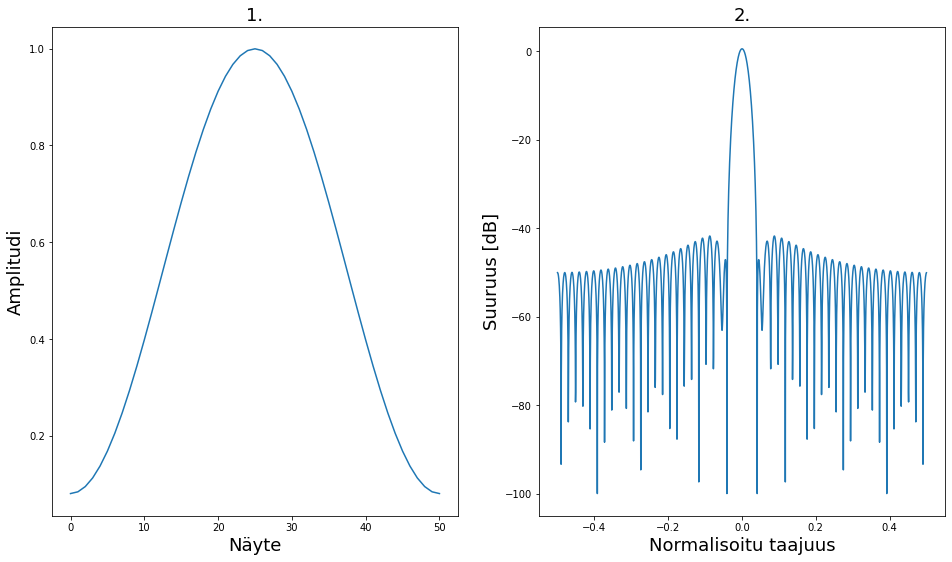

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, fftshift

window = np.hamming(51)


A = fft(window, 2048) / 25.5
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(mag)
response = np.clip(response, -100, 100)


fig, ax = plt.subplots(1,2, figsize=(16,9))
ax[0].plot(window)
ax[0].set_title('1.', fontsize=18)
ax[0].set_ylabel('Amplitudi', fontsize=18)
ax[0].set_xlabel('Näyte', fontsize=18)

ax[1].plot(freq,response)
ax[1].set_title('2.', fontsize=18)
ax[1].set_ylabel('Suuruus [dB]', fontsize=18)
ax[1].set_xlabel('Normalisoitu taajuus', fontsize=18)

plt.show()
fig.savefig('../figures/Hamming-window.png')

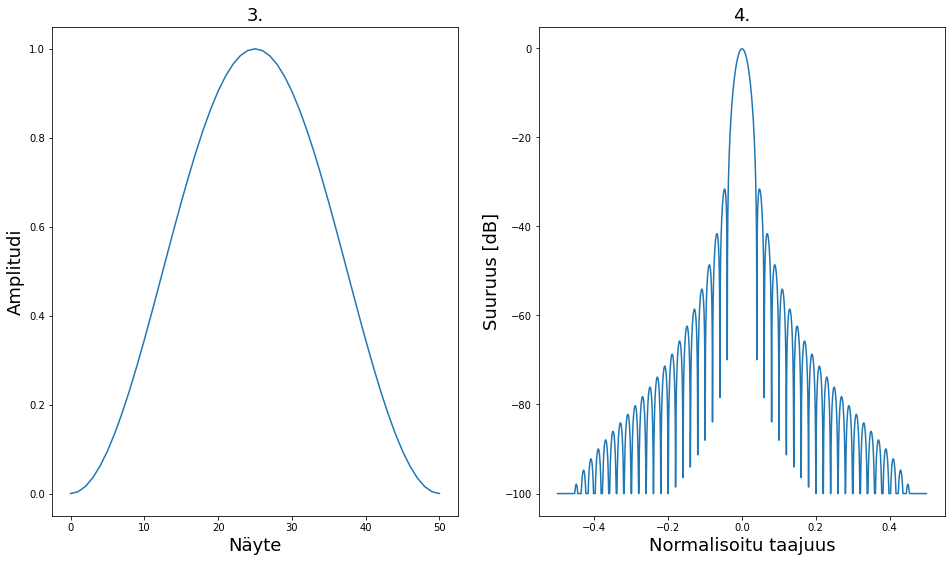

In [7]:
window = np.hanning(51)
A = fft(window, 2048) / 25.5
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))

with np.errstate(divide='ignore', invalid='ignore'):
    response = 20 * np.log10(mag)
response = np.clip(response, -100, 100)


fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].plot(window)
ax[0].set_title('3.', fontsize=18)
ax[0].set_ylabel('Amplitudi', fontsize=18)
ax[0].set_xlabel('Näyte', fontsize=18)

ax[1].plot(freq, response)
ax[1].set_title('4.', fontsize=18)
ax[1].set_ylabel('Suuruus [dB]', fontsize=18)
ax[1].set_xlabel('Normalisoitu taajuus', fontsize=18)

plt.show()
fig.savefig('../figures/Hann-window.png')
